In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
# Step 1: Load the dataset
# Replace 'your_dataset.csv' with the actual file path
data = pd.read_csv('merged_TimeWVHT_data.csv')

In [4]:
data.rename(columns={'#YY': 'Year', 'MM': 'Month', 'DD': 'Day'}, inplace=True)
# Combine Year, Month, and Day into a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Sort by the new 'Date' column
data = data.sort_values(by='Date')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

In [5]:
# Step 3: Normalize the features and target variable
# We are only using time-related features (Year, Month, Day) as inputs
features = ['Year', 'Month', 'Day']  # Use renamed columns
target = 'WVHT'  # The wave height column

# Normalize the features and the target variable using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

data[features] = scaler_features.fit_transform(data[features])
data[target] = scaler_target.fit_transform(data[[target]])

In [6]:
# Step 4: Create sequences for LSTM input
def create_sequences(data, target_col, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps][features].values)
        y.append(data.iloc[i + time_steps][target_col])
    return np.array(X), np.array(y)

time_steps = 10  # Number of past time steps to use for prediction
X, y = create_sequences(data, target_col=target, time_steps=time_steps)

In [7]:
# Step 5: Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Step 6: Build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, len(features))),
    Dense(1)  # Output layer predicting WVHT
])
model.compile(optimizer='adam', loss='mse')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Step 7: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0686 - val_loss: 15.2737
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 15.1265
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - val_loss: 15.6330
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 15.5394
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 15.8734
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 15.9550
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 15.8792
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 16.0073
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 16.0248
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - val_loss: 16.1341
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - val_loss: 15.6941
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.01

In [21]:
# Step 8: Make predictions
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [22]:
# Inverse scale the predictions and true values for interpretation
y_pred = scaler_target.inverse_transform(y_pred)
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

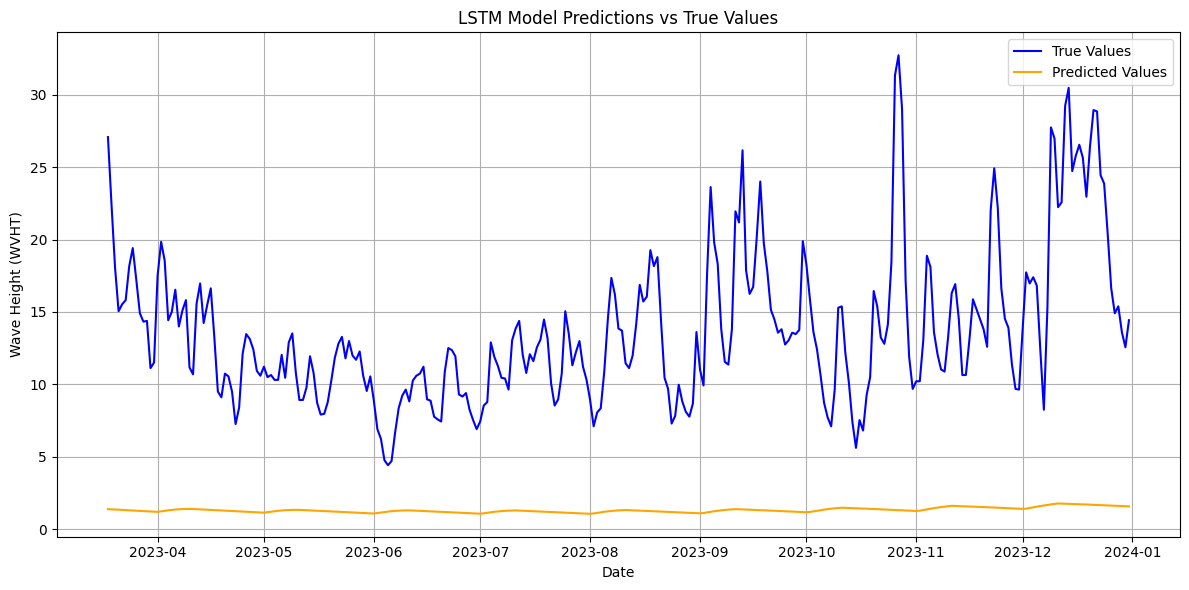

In [23]:
# Step 9: Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label='True Values', color='blue')
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Values', color='orange')
plt.xlabel('Date')
plt.ylabel('Wave Height (WVHT)')
plt.title('LSTM Model Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()